This project deals with a dataset of the loan applications made to a housing finance company in the past, along with the details of their approval/rejection. The plan is to automate the process of loan approval, and for this we have been asked to  use the given data to train an appropriate predictive algorithm. In this work, we shall explore the dataset in detail, clean it, add new features, and do some predictions using machine learning. 

More details of the problem, including the problem description and dataset can be obtained from the link below:
https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/
The given dataset contains a training and test set. We are expected to train the models on the training set, and upload the predictions made on the test set

In [1061]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn import metrics
warnings.filterwarnings('ignore')


In [1062]:
# Load the data set
train = pd.read_csv("train.csv")


Once the dataset is loaded, we can take a look at variables in it

In [1149]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We see that there are 13 fields/columns in the data set. Most of the fields are self-explanatory, such as Gender, Married, Dependents, Education and Self_Employed.
As for the remaining items, a brief description is below:

**ApplicantIncome, CoapplicantIncome**: The monthly income of applicant or coapplicant in rupees

**Loan_Amount**: The amount of loan in thousands of rupees

**Loan_Amount_Term**: The duration of the loan in months

**Credit_History**: Whether the applicant satisfies the requirements of credit history

**Property_Area**: The location of the desired property

**Loan_Status**: Whether the application was approved or not


Having had a first look at the different variables, it is a good idea to look at a short summary of dataset, which is shown below.

In [1064]:
train.shape

(614, 13)

There are 614 entries in the training set. However, there are a number of NA values in several of the columns as can be seen below

In [1065]:
train.count()

Loan_ID              614
Gender               601
Married              611
Dependents           599
Education            614
Self_Employed        582
ApplicantIncome      614
CoapplicantIncome    614
LoanAmount           592
Loan_Amount_Term     600
Credit_History       564
Property_Area        614
Loan_Status          614
dtype: int64

These missing values need to be imputed before proceeding with using this dataset for training prediction algorithms. But before that, let us explore the dataset in detail, with whatever values are available

Let's look at the proportion of male and female applicants

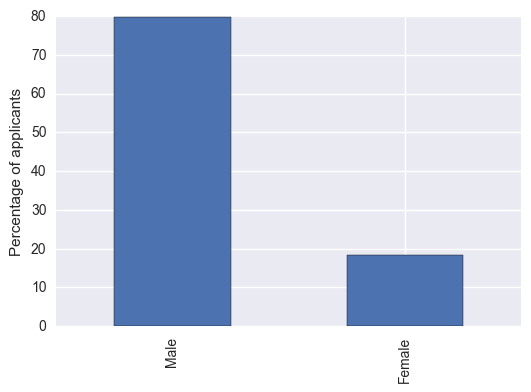

In [1066]:
%matplotlib inline
total_applicants = train.shape[0]
plt1 = (train["Gender"].value_counts()/(total_applicants)*100).plot(kind="bar")
plt1.set_ylabel("Percentage of applicants")

   **Fig 1. Percentage of Males and Females in the dataset** 

We see that about 80% of the applicants are Male. Now let us take a look at the data based on gender and marital status

OrderedDict([('Female, Married', 13.029315960912053),
             ('Male, Married', 58.143322475570031),
             ('Male, Unmarried', 21.172638436482085),
             ('Female, Unmarried', 5.0488599348534198)])

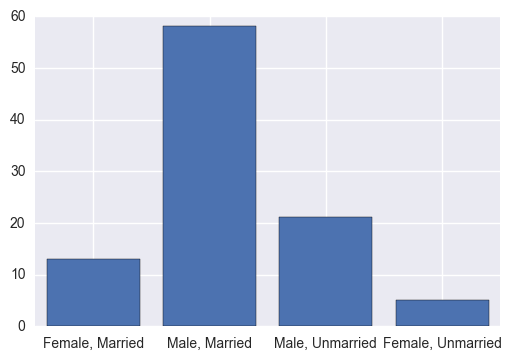

In [1067]:
male_mar_perc = (train.groupby("Gender").get_group("Male")["Married"].value_counts()[0])*100/total_applicants
male_unmar_perc = (train.groupby("Gender").get_group("Male")["Married"].value_counts()[1])*100/total_applicants
female_mar_perc = (train.groupby("Gender").get_group("Female")["Married"].value_counts()[0])*100/total_applicants
female_unmar_perc = (train.groupby("Gender").get_group("Female")["Married"].value_counts()[1])*100/total_applicants
from collections import OrderedDict
plot_list = OrderedDict({'Male, Married':male_mar_perc,'Male, Unmarried':male_unmar_perc,'Female, Married':female_mar_perc,'Female, Unmarried':female_unmar_perc})
plt.bar(range(len(plot_list)),plot_list.values(),align="center")
plt.xticks(range(len(plot_list)),plot_list.keys())
plot_list

**Fig 2. Percentage of Males and Females according to marital status**

The majority of the applicants are married males. The percentage of female applicants is already low, of which the percentage of unmarried females is still lower.
(Note: The figures above might not add up to a total of 100%, since we are ignoring the missing values in the dataset, whereas the percentage is calculated out of the total number of applicants. Strictly speaking this might not be accurate, but it still gives a qualitative trends in the dataset)

Let's take a look at the number distribution of data according to the number of dependents 

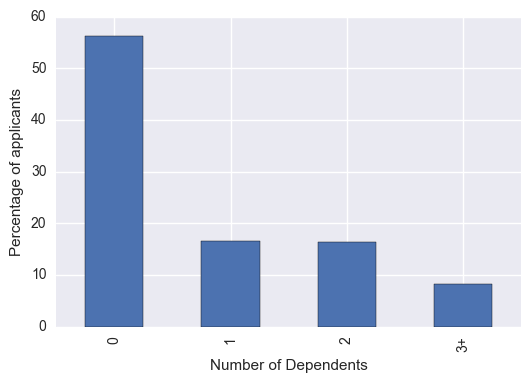

In [1068]:
plt2 = (train["Dependents"].value_counts()/(total_applicants)*100).plot(kind="bar")
plt2.set_ylabel("Percentage of applicants")
plt2.set_xlabel("Number of Dependents")

**Fig 3. Percentage of applicants according to number of dependents**

Majority of the applicants do not have any dependents. The proportion of applicants with 1 or 2 dependents are similar, while applicants with 3 or more dependents are the lowest. Lets classify this further according to the gender of the applicants

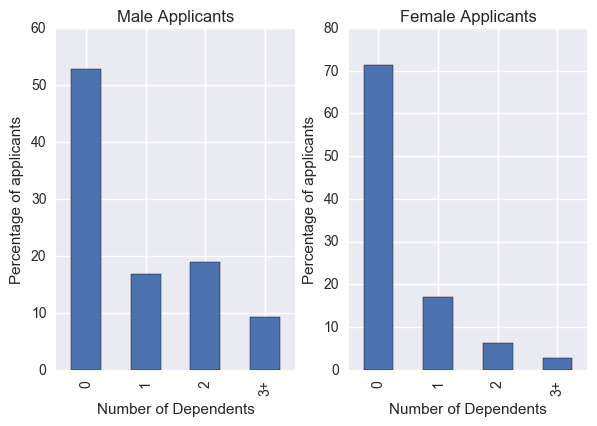

In [1069]:
fig3 = plt.figure()
ax1 = plt.subplot(121)
#ax3 = plt.subplots(1,2)
ax2 = plt.subplot(122)
fig3.tight_layout()

total_male_applicants = train.groupby("Gender").get_group("Male").shape[0]

data_plt3 = (train.groupby("Gender").get_group("Male")["Dependents"].value_counts()/(total_male_applicants)*100)
# define a list of labels by which the bar chart will be ordered. Else the chart will be plotted in descending order
order = ['0','1','2','3+']

plt3 = data_plt3.ix[order].plot(kind="bar",ax=ax1)
plt3.set_ylabel("Percentage of applicants")
plt3.set_xlabel("Number of Dependents")
plt3.set_title("Male Applicants")

total_female_applicants = train.groupby("Gender").get_group("Female").shape[0]

data_plt4 = (train.groupby("Gender").get_group("Female")["Dependents"].value_counts()/(total_female_applicants)*100)

plt4 = data_plt4.ix[order].plot(kind="bar",ax=ax2)
plt4.set_ylabel("Percentage of applicants")
plt4.set_xlabel("Number of Dependents")
plt4.set_title("Female Applicants")

**Fig 4. Percentage of Male and Female applicants according to number of dependetns**

Over 70% of the female applicants have no dependents, and with the percentage decreasing with increasing number of applicants. In case of males, although the majority has no dependents, the figure is slightly lower at about 55%. about 20% have 2 dependents, a slightly lower figure for those with 1 dependent and less than 10% with 3+ applicants

(0, 90)

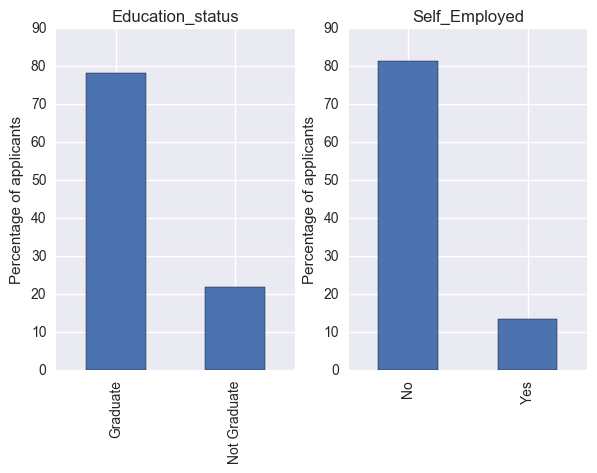

In [1152]:
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fig.tight_layout()
total_applicants = train.shape[0]
plot1 = (train["Education"].value_counts()/(total_applicants)*100).plot(kind="bar",ax=ax1)
plot1.set_ylabel("Percentage of applicants")
#plot1.set_xlabel("Education_status")
plot1.set_title("Education_status")
plot1.set_ylim(0,90)

plot2 = (train["Self_Employed"].value_counts()/(total_applicants)*100).plot(kind="bar",ax=ax2)
plot2.set_ylabel("Percentage of applicants")
#plot2.set_xlabel("Employment_status")
plot2.set_title("Self_Employed")
plot2.set_ylim(0,90)

**Fig. 5 Percentage of Graduates , Non graduataes, Self Employed and Non-Self Employed applicants**

Slightly under 80% of the applicants are graduates, and a bit over 80% of the applicants are not self employed.
The distribution of incomes of the applicant and co-applicant, and the loan amount are shown in the figure below. All three quantities seems to have a bunch of outliers. Note that the Loan Amount is shown in 1000s of units whereas the applicant and co-applicant income are shown in actual units. The highest, lowest and median values are lower for co-applicant income than applicant income. Half of the loans are between 100,000 and 200,000, with some very small and very high loans seen as well

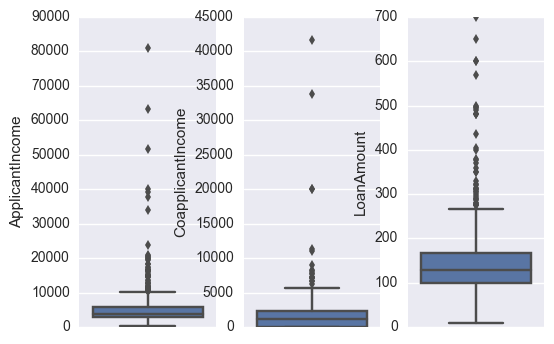

In [1148]:
fig = plt.figure()
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
sns.boxplot(y="ApplicantIncome",data=train,ax=ax1)
sns.boxplot(y="CoapplicantIncome",data=train,ax=ax2)
sns.boxplot(y="LoanAmount",data=train,ax=ax3)

**Fig 6. Distribution of applicant, coapplicant Income and loan amount in the data set**

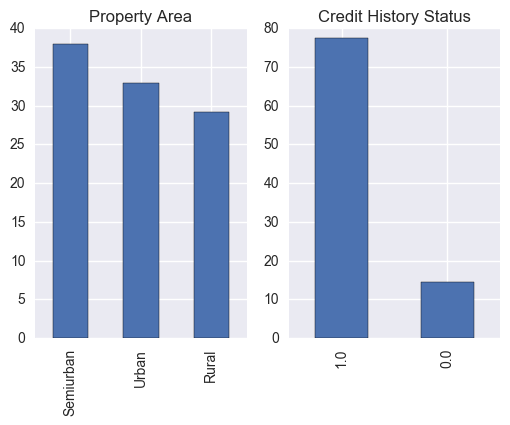

In [1157]:
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
plot1 = (train["Property_Area"].value_counts()*100/train.shape[0]).plot(kind="bar",ax=ax1,title="Property Area")
plot2 = (train["Credit_History"].value_counts()*100/train.shape[0]).plot(kind="bar",ax=ax2,title="Credit History Status")

**Fig 7. Distribution of applicantions according to property location and requirements of credit history**

And lastly, we see that most of the applicantions are for properties in Semi Urban areas, followed by urban and rural areas. About 80% of the applications satisfy the required credit history, while the others dont'. (Again, the percentages might not add up, since we have ignored the missing data in these figures) 

Lets now take a look at the dataset keeping in view the approval status of loans. Let us split the dataset into the cases where the loan was approved and loan was not approved. First lets look at the distribution

In [1071]:
#train_male = train.groupby("Gender").get_group("Male")
#train_female = train.groupby("Gender").get_group("Female")
#total_male_applicants = train_male.shape[0]
#total_female_applicants=train_female.shape[0]

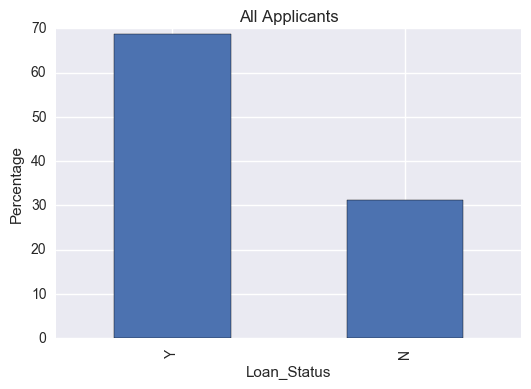

In [1072]:
#plt = (train_male["Loan_Status"].value_counts()*100/total_male_applicants).plot(kind="bar")
#plt.set_xlabel("Loan_Status")
#plt.set_ylabel("Percentage")
#plt.set_title("Male Applicants")

plot = (train["Loan_Status"].value_counts()*100/total_applicants).plot(kind="bar")
plot.set_xlabel("Loan_Status")
plot.set_ylabel("Percentage")
plot.set_title("All Applicants")

**Fig 8. Percentage of approval and rejection of applications**

If we analyze the dataset as a whole, we see that about 70% of the applications were accepted, and the rest were rejected. This proportions should be kept in mind, since deviation from these percentages when we later look at the data categorized by different variables might show the effect of those variables

In [1073]:
def plot_bar_chart(df,groupby_var,group,title,axis,xorder=None):
    train_group = df.groupby(groupby_var).get_group(group)
    total_group_applicants = train_group.shape[0]
    if xorder == None:
        plot = (train_group["Loan_Status"].value_counts()*100/total_group_applicants).plot(kind="bar",ax=axis)
    else:
        plot = ((train_group["Loan_Status"].value_counts()*100/total_group_applicants)).ix[xorder].plot(kind="bar",ax=axis,x=xorder)
    
    plot.set_xlabel("Loan_Status")
    plot.set_ylabel("Percentage")
    plot.set_ylim([0,80])
    plot.set_title(title) 
    

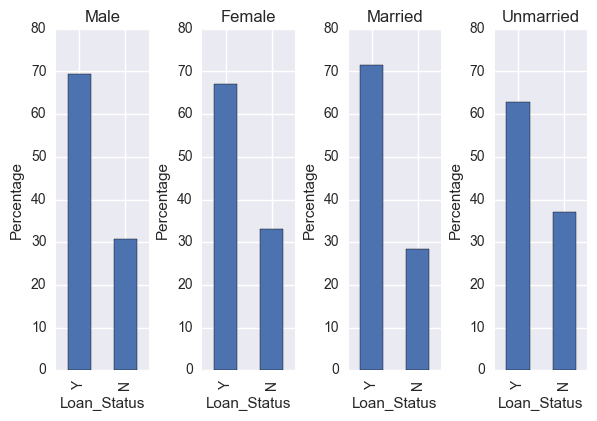

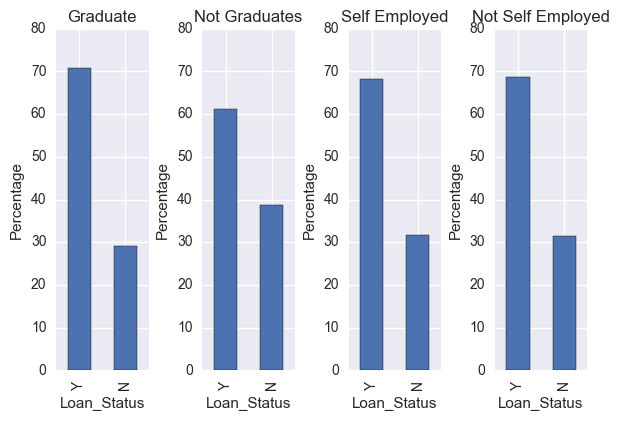

In [1074]:
fig4a = plt.figure()

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
fig4a.tight_layout()

plot_bar_chart(train,"Gender","Male","Male",ax1)
plot_bar_chart(train,"Gender","Female","Female",ax2)
plot_bar_chart(train,"Married","Yes","Married",ax3)
plot_bar_chart(train,"Married","No","Unmarried",ax4)
#fig4.subplots_adjust(hspace=0.5)
#fig4 = plt.figure(3,4)

fig4b = plt.figure()

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
fig4b.tight_layout()
#fig3,ax3 = plt.subplots(1,2)
#fig4a,ax4a = plt.subplots(1,4)
fig4b.tight_layout()
plot_bar_chart(train,"Education","Graduate","Graduate",ax1)
plot_bar_chart(train,"Education","Not Graduate","Not Graduates",ax2)
plot_bar_chart(train,"Self_Employed","Yes","Self Employed",ax3)
plot_bar_chart(train,"Self_Employed","No","Not Self Employed",ax4)
#axis[0]

**Fig 9. Loan approval rate according to gender, marital status, education and type of employment**

The acceptance rates of applications are about the same for males and females, whic is approximately similar to what we observe in the population. So is the case between applicants who are self employed and not self employed. Hence, these factors might not be influencing the chance of application approval. However, we see that the rejection rates of applicatoin is slightly higher among unmarried applicants in comparison to the married applicants who have similar acceptance/rejection rate as the population. A similar observation can be made about applicants who are non-graudates.

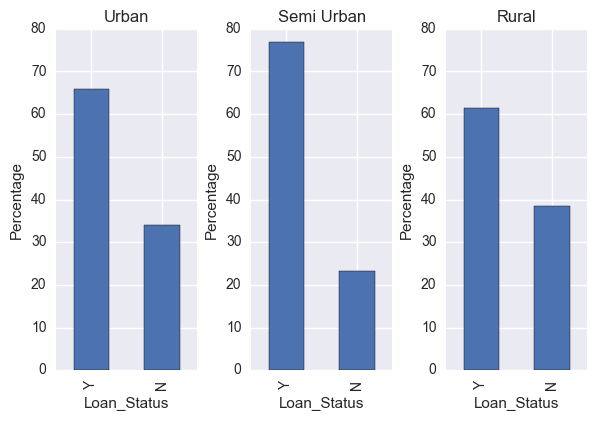

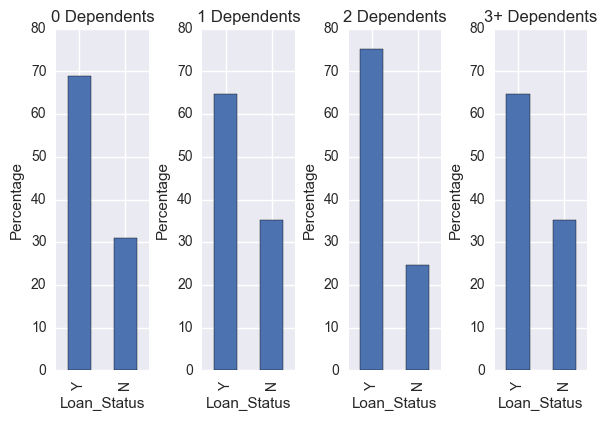

In [1075]:
fig5 = plt.figure()
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
fig5.tight_layout()

plot_bar_chart(train,"Property_Area","Urban","Urban",ax1)
plot_bar_chart(train,"Property_Area","Semiurban","Semi Urban",ax2)
plot_bar_chart(train,"Property_Area","Rural","Rural",ax3)

fig6 = plt.figure()
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
fig6.tight_layout()

plot_bar_chart(train,"Dependents","0","0 Dependents",ax1)
plot_bar_chart(train,"Dependents","1","1 Dependents",ax2)
plot_bar_chart(train,"Dependents","2","2 Dependents",ax3)
plot_bar_chart(train,"Dependents","3+","3+ Dependents",ax4)


**Fig 10. Percentage of loan approval according to property area and number of dependents **

Based on the locality of the property, we see that semi-urban areas have highest chance of acceptance, followed by urban and rural areas. Applicants with 2 dependents had the highest accpetance rate, followed by those with 0 dependents, and then by those with 1 and 3+ dependents whose acceptance rate is slightly lower. 


One important variable in the context of loan application that must be checked is the credit history of the applicant. Lets take a look at the effect of credit history on loan approval status

(0, 100)

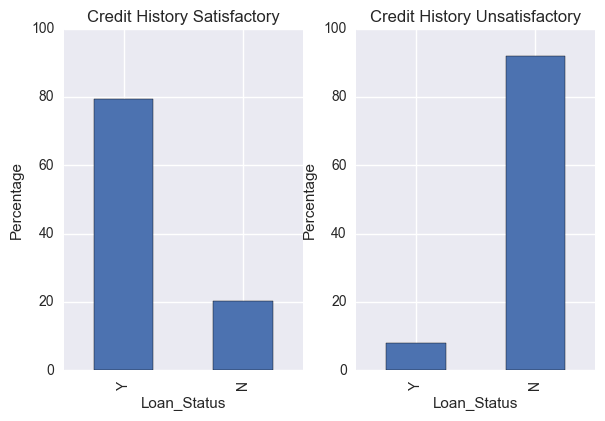

In [1076]:
fig6 = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fig6.tight_layout()
order=['Y','N']
plot_bar_chart(train,"Credit_History",1,"Credit History Satisfactory",ax1,xorder=order)
plot_bar_chart(train,"Credit_History",0,"Credit History Unsatisfactory",ax2,xorder=order)
ax1.set_ylim(0,100)
ax2.set_ylim(0,100)

**Fig 11. Percentage of loan approval according to credit history**

As expected, there is a HUGE dependence of the approval status on the credit history of the applicant. If the applicant has a satisfactory credith history, (s)he has about 80% chance of success with the application. In contrast, for a person with unsatisfactory credit history, there is less than 10% chance of success.

It would be worthwile, however, to investigate why 20% of applicants were rejected despite having a satsifactory credit history, and how the minority of applicants (<10%) whose applications were approved despite having an unsatisfactory credit history, based on the rest of the applicant information. However, before venturing into that aspect, let us look into a few more aspects such as applicant income, co-applicant, loan amount and loan amount term.

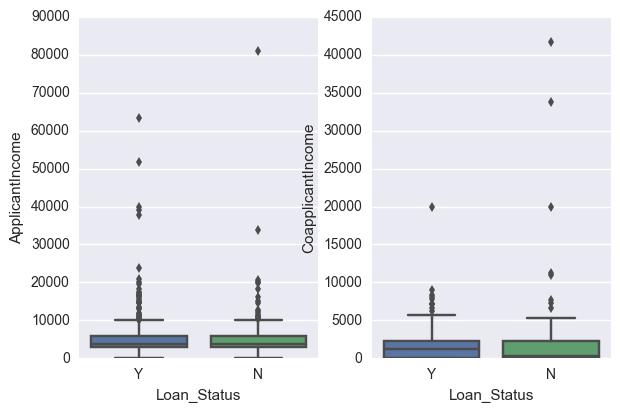

In [1077]:
fig7 = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fig7.tight_layout()
sns.boxplot(x="Loan_Status",y="ApplicantIncome",data=train,ax=ax1)
sns.boxplot(x="Loan_Status",y="CoapplicantIncome",data=train,ax=ax2)

**Fig 12. Distribution of applicant and coapplicant income according to loan approval status**

In [1078]:
display(train["ApplicantIncome"].isnull().sum())
display(train["CoapplicantIncome"].isnull().sum())
display(train.groupby("Loan_Status").ApplicantIncome.median())
display(train.groupby("Loan_Status").CoapplicantIncome.median())



0

0

Loan_Status
N    3833.5
Y    3812.5
Name: ApplicantIncome, dtype: float64

Loan_Status
N     268.0
Y    1239.5
Name: CoapplicantIncome, dtype: float64

The distribution of applicant income is approximately same among the accepted and rejected case, with the median values also very close to each other. In case of co-applicant income, the median value is lower than their corresponding income for accepted applications. For rejected candidates, the median co-applicant income is much lower  
(Note that there are no missing values for applicant and coapplicant income in the entire data set)


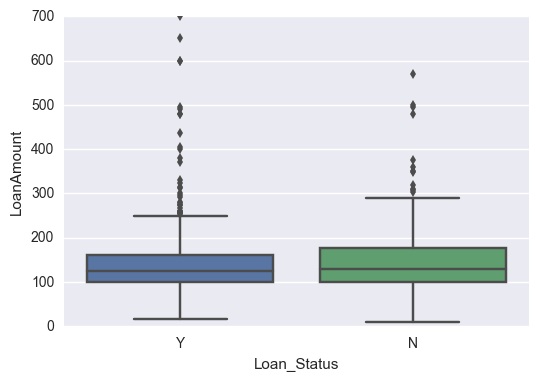

In [1079]:
sns.boxplot(x="Loan_Status",y="LoanAmount",data=train)

**Fig 13. Distribution of Loan Amount according to loan approval status**

In [1080]:
display(train.groupby("Loan_Status").LoanAmount.median())

Loan_Status
N    129.0
Y    126.0
Name: LoanAmount, dtype: float64

Now that we have done some basic exploration of the data set, let us check for missing values in the data set and correct them. Before doing this, let's combine the training and test dataset into a single data set. Note that the test data set does not have the column for Loan Status, hence, this field needs to be created as an empty colum to combine with training set.


In [1081]:
test = pd.read_csv("test.csv")
test["Loan_Status"]=0


In [1082]:
all_data = train.append(test,ignore_index=True)

In [1083]:
pd.isnull(all_data).any()

Loan_ID              False
Gender                True
Married               True
Dependents            True
Education            False
Self_Employed         True
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount            True
Loan_Amount_Term      True
Credit_History        True
Property_Area        False
Loan_Status          False
dtype: bool

The columns Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term and Credit_History have missing values. We will look at each of these separately and decide on the best ways to impute the values. Lets first look at the number of missing values in Gender field

In [1085]:
all_data["Gender"].isnull().sum()

24

From figure 1, over 80% of the applicants are male. Hence a relatively simple method to fill in the 24 values would be to simply specify it as "Male" 

In [1086]:
all_data["Gender"].fillna("Male",inplace=True)

Next, we look at the "Married" field.

In [1088]:
all_data["Married"].isnull().sum()

3

There are only three values. Lets check out these rows in the data set


In [1089]:
all_data[all_data["Married"].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


For the case with LoanID LP001357, we see that the applicant is male with CoapplicantIncome value is not equal to zero. Hence, most likely the applicant is married. For the case with LoanID LP002393, the applicant is female, with coapplicant income value as zero. Hence, it is most likely that the applicant not married. For the case LP001760, the applicant is male, with zero CoapplicantIncome. However, since over 73% of the male applicants are married, (as can be seen from the table below which shows the proportionso of males and females who are married) let us assume that this applicant is married 

In [1090]:
pd.crosstab(all_data.Gender,all_data.Married).apply(lambda r: r/r.sum(),axis=1)

Married,No,Yes
Gender,,
Female,0.685083,0.314917
Male,0.279799,0.720201


In [1091]:
all_data.iloc[104,2]="Yes"
all_data.iloc[228,2]="Yes"
all_data.iloc[435,2]="Yes"

Let's check the self_employed variable now

In [1092]:
all_data["Self_Employed"].isnull().sum()

55

55 entries are missing. Let us look at the general trend in the dataset

In [1093]:
all_data.Self_Employed.value_counts()

No     807
Yes    119
Name: Self_Employed, dtype: int64

About 87% of the applicatns are not self employed. Hence, lets impute the missing values at Not Self Employed

In [1094]:
all_data.Self_Employed.fillna("No",inplace=True)

Now, let us look at the missing values in Dependents

In [1098]:
all_data["Dependents"].isnull().sum()

25

There are 25 rows with values of dependents missing. Before deciding on how to impute this data, it would be worthwhile to look at the table below, which shows the percentage of applicants with 0,1,2,or 3+ dependents segregated according to their gender and marital status. We see that in cases of females, and unmarried males, there is greater than 60% chance that the applicant has no dependents (as high as 85% in case of unmarried males). Hence in all such cases we will impute the number of dependents as zero. The only difficulty arises in case of married males. For those cases, we will use machine learning algorithms to predict the number of dependents.

In [1099]:
(pd.crosstab([train.Gender, train.Married], train.Dependents)).apply(lambda r: r/r.sum(),axis=1)

Dependents             0         1         2        3+
Gender Married                                        
Female No       0.769231  0.166667  0.025641  0.038462
       Yes      0.645161  0.193548  0.161290  0.000000
Male   No       0.851562  0.078125  0.046875  0.023438
       Yes      0.426934  0.206304  0.246418  0.120344

In [1100]:
#Imputing missing dependents of all Female applicants as 0
all_data.loc[(all_data["Gender"]=="Female")&(all_data["Dependents"].isnull()),"Dependents"]=0

In [1101]:
#Imputing missing dependents of all unmarried mmale applicants as 0
all_data.loc[(all_data["Gender"]=="Male")&(all_data["Married"]=="No")&(all_data["Dependents"].isnull()),"Dependents"]=0

For the rest of the values, let us use a basic decision tree classifier to impute the missing values. This is done by training the decision tree using the data from those cases of married males with non-missing values for dependents (which forms the training set),and using it to predict those rows with the missing values (which forms the test set). Let us now create this training and test set.
For predicing the number of dependents, we shall use the variables ApplicantIncome, CoapplicantIncome, LoanAmount, and Property Area

In [1102]:
all_data.loc[all_data["Dependents"]=="3+","Dependents"]=3
all_data["Dependents"]=all_data["Dependents"].astype(float)
male_married = all_data[(all_data["Gender"]=="Male")&(all_data["Married"]=="Yes")]

In [1103]:
train_dep_pred  = male_married[np.isfinite(male_married["Dependents"])]
test_dep_pred = male_married[male_married["Dependents"].isnull()]

In [1104]:
test_dep_pred["LoanAmount"].isnull().sum()
#test_dep_pred.shape
#all_data[(all_data["Gender"]=="Male")&(all_data["Married"]=="Yes")&(all_data["Dependents"].isnull())&(np.isfinite(all_data["LoanAmount"]))]

2

In this training set, there are 16 rows with LoanAmount missing, and in the test set, there are 2 values missing Let us drop these values for the time being.


In [1105]:
train_dep_pred = train_dep_pred[np.isfinite(train_dep_pred["LoanAmount"])]
test_dep_pred = test_dep_pred[np.isfinite(test_dep_pred["LoanAmount"])]

Let us now define a generic function for classification, including in-build cross-validation action. This function we shall use later for our final prediction of loan application approval as well.

In [1106]:
def classify(model,data,features,target,CV=None):
    #Fit the model
    model.fit(data[features],data[target])
    predictions = model.predict(data[features])
    accuracy = metrics.accuracy_score(predictions,data[target])
    print("Prediction Accuracy on Trainig Set")
    print(accuracy)
    
    if CV==True:
        #k-fold cross-validation
        kf = KFold(n_splits=5)
        error = []
        for train,test in kf.split(data[features]):
            train_features = data[features].iloc[train,:]
            train_target = data[target].iloc[train]
            model.fit(train_features,train_target)
            error.append(model.score(data[features].iloc[test,:],data[target].iloc[test]))
        print("Cross Validation Score")
        print(np.mean(error))
    model.fit(data[features],data[target])
        

In [1107]:
#Scaling of ApplicantIncome, CoapplicantIncome and LoanAmount before using it as features
from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#train_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]] = min_max_scaler.fit_transform(train_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]])
#test_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]] = min_max_scaler.fit_transform(test_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]])
train_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]] = preprocessing.scale(train_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]])
test_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]] = preprocessing.scale(test_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]])

#Changing categorical variables to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_dep_pred["Property_Area"] = le.fit_transform(train_dep_pred["Property_Area"])
test_dep_pred["Property_Area"] = le.fit_transform(test_dep_pred["Property_Area"])

features= [ "CoapplicantIncome", "LoanAmount", "Property_Area"]
target = ["Dependents"]

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#test_model = LogisticRegression()
tree_model = DecisionTreeClassifier(max_depth=4,min_samples_split = 70)



In [1108]:
classify(tree_model,train_dep_pred,features,target,CV=True)


Prediction Accuracy on Trainig Set
0.484403669725
Cross Validation Score
0.440366972477


The cross validation accuracy is only marginally better than than the accuracy we would obtain by imputing dependents with the mode value (=0), which is 0.42 (calculation not shown here, but can be verified). Therefore, we can either use the predictions of this classifier or impute the missing values dependents column with 0.
For now, let us impute with the predictions obtained above

In [1109]:
test_predictions = tree_model.predict(test_dep_pred[features])
all_data.loc[(all_data["Gender"]=="Male")&(all_data["Married"]=="Yes")&(all_data["Dependents"].isnull())&(np.isfinite(all_data["LoanAmount"])),"Dependents"] = test_predictions

Now, there are only two more rows with Dependents values missing, which are the ones we dropped from earlier due to non-available LoanAmount value. Let us impute these last two rows with value 0

In [1110]:
all_data["Dependents"].fillna(0,inplace=True)

So far we have imputed missing values for Gender, Married, Dependents and Self Employed. Next we shall take LoanAmout, for which we will use a linear regression model to predict based on Gender,ApplicantIncome,CoApplicantIncome,Married, Dependents & Property_Area

In [1111]:
train_LnAmt_pred = all_data[np.isfinite(all_data["LoanAmount"])]
test_LnAmt_pred = all_data[all_data["LoanAmount"].isnull()]
#pd.crosstab(all_data.Gender,all_data.Married,values=all_data.LoanAmount,aggfunc=np.median)

In [1112]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#train_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]] = min_max_scaler.fit_transform(train_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]])
#test_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]] = min_max_scaler.fit_transform(test_dep_pred[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]])

#Scaling
train_LnAmt_pred[["ApplicantIncome", "CoapplicantIncome"]] = preprocessing.scale(train_LnAmt_pred[["ApplicantIncome", "CoapplicantIncome"]])
test_LnAmt_pred[["ApplicantIncome", "CoapplicantIncome"]] = preprocessing.scale(test_LnAmt_pred[["ApplicantIncome", "CoapplicantIncome"]])

#Label Encoding

train_LnAmt_pred["Property_Area"] = le.fit_transform(train_LnAmt_pred["Property_Area"])
test_LnAmt_pred["Property_Area"] = le.fit_transform(test_LnAmt_pred["Property_Area"])

train_LnAmt_pred["Gender"] = le.fit_transform(train_LnAmt_pred["Gender"])
test_LnAmt_pred["Gender"] = le.fit_transform(test_LnAmt_pred["Gender"])

train_LnAmt_pred["Married"] = le.fit_transform(train_LnAmt_pred["Married"])
test_LnAmt_pred["Married"] = le.fit_transform(test_LnAmt_pred["Married"])

features = ["Gender","ApplicantIncome","CoapplicantIncome","Married","Dependents","Property_Area"]
X = train_LnAmt_pred[features]
y = train_LnAmt_pred["LoanAmount"]
X_test = test_LnAmt_pred[features]
lin_model.fit(X,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1113]:
predictions = lin_model.predict(X_test)
all_data.loc[all_data["LoanAmount"].isnull(),"LoanAmount"]=predictions
#sns.boxplot(x="Dependents",y="LoanAmount",data=all_data)

Having done this, the only fields left with missin values are Loan_Amount_Term and credit_history. Let's take Loan_Amount_Term first. 



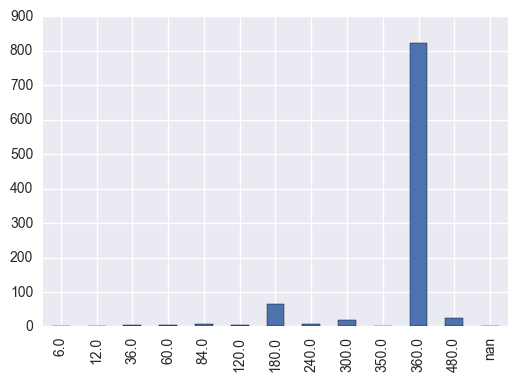

In [1114]:
order = np.sort(pd.unique(all_data["Loan_Amount_Term"]))
(all_data["Loan_Amount_Term"].value_counts()).ix[order].plot(kind="bar")

**Fig 14. Distribution of Loan Amount Terms**

About 90% of the loans are for 360 months duration. Hence, lets impute the missing values as 360

In [1115]:
all_data["Loan_Amount_Term"].fillna(360,inplace=True)

In [1116]:
all_data["Credit_History"].isnull().sum()

79

In [1117]:
all_data.loc[all_data["Credit_History"].isnull()]["Loan_Status"].value_counts()

Y    37
0    29
N    13
Name: Loan_Status, dtype: int64

The last variable to impute is credit history. We see that there are 79 rows in total with value missing for credit history. Of these, 29 of the values are in the test set.  We saw earlier, that credit history is the most important criterion for granting or rejecting a loan application, and hence we should be very careful in dealing with this variable. There are several lines of reasoning that can be applied:

1) **An unavailable credit history is as good as having a bad credit history for practical purposes, and hence unavilable credit histories should imputed as zero:** However, this might not be a very good idea, since we see that of the 50 rows in training data with Credit History value missing, 37 of the cases were approved, whereas only 13 were rejected. Going by the trend in the data set we, see that an unsatisfactory credit history has over 90% chance of rejection. This trend is in direct contradiction to what we would be doing if we apply blanket 0 imputation on missing credit history values

2) **Impute all the missing values as 1:** This option would be better, since this method will make sure that the missing rows after imputation will reflect a trend of 74% (37/50) acceptance with satisfactory credit history and 26% rejection. This is infact closer to the trend in the actual data set

3) ** Treat the missing values as a new category**: Treat the missing cases as a new category, i.e, 2 instead of 0 or 1. However it is not clear if this method would help the algorithms make better predictions. 

4) **Use the loan status to predict values of credit history in training set(Y =1,N=0). Impute with 1 or 0 in the test set:** This method is still not recommended, since by doing such an imputation on the training set, we will be re-inforcing the dependence on loan application approval on credit history, making it more all the more difficult to make predictions on those cases that don't follow this rule, which would be a serious disadvantage

5) **USE ML algorithms to predict the credit history value based on other features except loan status in the dataset** :This is a tedious method, however, its efficacy should be tested

Of all the methods listed above, let us go ahead with 2, since that looks the most optimal among all the options [Note: Method 5 was tested separately, however, it did not seem to help much]




In [1118]:
all_data["Credit_History"].fillna(1,inplace=True)

Thus, we have done imputing all the missing values in the data set. Next, we need to prepare the data set by doing some standard operations (of scaling and conversion of factor variables to numeric), followed by some feature engineering before using it to train any algorithms for prediction. Let us first slice back the training set and test set 

In [1119]:
train_clean = all_data.iloc[0:614,]
test_clean = all_data.iloc[614:,]

In [1120]:
train_clean.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,112.781022,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


Let us convert all the factor variables to numeric

In [1121]:
for factor in ["Gender","Married","Education","Self_Employed","Property_Area","Loan_Status"]:
    train_clean[factor]=le.fit_transform(train_clean[factor])
    test_clean[factor]=le.fit_transform(test_clean[factor])
    

Now, let us generate some additional features. The ability of an applicant to pay back a loan is dependent on a number of factors such as the income of the applicant (and co-applicant if applicable), total number of dependents, total loan amount and loan amount term. Let us hence calculate a new feature called "EMI", which is the montly installment expected of the applicants. In order to calculate the EMI, we need a value for the interest rate, which is however not provided with the dataset. We can chose to ignore any interest on the loan, but that would not be a realistic scenario, and an EMI value without interest would be too low and does not make sense. 

Hence for this purpose, let us use an interest rate of 8.5% p.a (which is the value around which rates in India hovers). The forumla for EMI then becomes : 
                    
                    EMI = [PxRx(1+R)^N]/[(1+R)^N-1]
                    
    where P is the loan amount, R is the interest rate per month (in our case = 8.5/(12x100)) and N is the number of months for which the loan is given

In [1122]:
def calculate_EMI(df,rate):
    #EMI = (P*R*(1+R)**N)/((1+R)**N-1)
    P = df["LoanAmount"]*1000
    R = rate/(12*100)
    N = df["Loan_Amount_Term"]
    EMI = (P*R*(1+R)**N)/((1+R)**N-1)
    df["EMI"]=EMI
    
calculate_EMI(train_clean,8.5)
calculate_EMI(test_clean,8.5)


Now that we have calculated EMI, let us calcualte another feature representing the EMI to income ratio DTI. This will represent what proportion of the applicants total-income will be required to be paid as EMI. This single feature will represent all the information contained in ApplicantIncome, CoapplicantIncome, LoanAmount and Loan_Amount_Term in a single variable

In [1123]:
train_clean["DTI"] = train_clean["EMI"]/(train_clean["ApplicantIncome"]+train_clean["CoapplicantIncome"])
test_clean["DTI"] = test_clean["EMI"]/(test_clean["ApplicantIncome"]+test_clean["CoapplicantIncome"])

In [1124]:
train_clean.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,EMI,DTI
0,LP001002,1,0,0.0,0,0,5849,0.0,112.781022,360.0,1.0,2,1,867.188486,0.148263
1,LP001003,1,1,1.0,0,0,4583,1508.0,128.000000,360.0,1.0,0,0,984.209259,0.161584
2,LP001005,1,1,0.0,0,1,3000,0.0,66.000000,360.0,1.0,2,1,507.482899,0.169161
3,LP001006,1,1,0.0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1,922.696180,0.186743
4,LP001008,1,0,0.0,0,0,6000,0.0,141.000000,360.0,1.0,2,1,1084.168012,0.180695


Having done some feature engineering, let us now proceed with training a classification algorithm on the training set, and make predictions of the Loan_Status on the test set. We need to normalize the ApplicantIncome and CoapplicantIncome field before using them for training the algorithms

In [1125]:
train_clean[["ApplicantIncome","CoapplicantIncome"]] = preprocessing.scale(train_clean[["ApplicantIncome","CoapplicantIncome"]])
test_clean[["ApplicantIncome","CoapplicantIncome"]] = preprocessing.scale(test_clean[["ApplicantIncome","CoapplicantIncome"]])

In [1126]:
train_clean.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,EMI,DTI
0,LP001002,1,0,0.0,0,0,0.072991,-0.554487,112.781022,360.0,1.0,2,1,867.188486,0.148263
1,LP001003,1,1,1.0,0,0,-0.134412,-0.038732,128.000000,360.0,1.0,0,0,984.209259,0.161584
2,LP001005,1,1,0.0,0,1,-0.393747,-0.554487,66.000000,360.0,1.0,2,1,507.482899,0.169161
3,LP001006,1,1,0.0,1,0,-0.462062,0.251980,120.000000,360.0,1.0,2,1,922.696180,0.186743
4,LP001008,1,0,0.0,0,0,0.097728,-0.554487,141.000000,360.0,1.0,2,1,1084.168012,0.180695


Before proceeding with predictions, let us proceed with a baseline prediction method. We saw earlier, that credit history variable has a significant impact on the approval/rejection status of an application. Hence let us create a baseline prediction that Loan_Status = Y if Credit history = 1, or Loan_Status = N other wise. To test the accuracy of the model, let us create a new column, which will have value 1 if this condition is met, or 0 otherwise

In [1127]:
train_clean["baseline_pred_correct"]=0
train_clean.loc[(train_clean["Credit_History"]==train_clean["Loan_Status"]),"baseline_pred_correct"] = 1
baseline_accuracy = train_clean["baseline_pred_correct"].sum()/train_clean.shape[0]
baseline_accuracy

0.8094462540716613

the baseline accuracy is around 81%. Hence we could just use this method and get a decent accuracy rate. It remains to see if any of the standard classification algorithms would yield better accuracy

In [1128]:
#Define Classifier
features = ["Gender","Married","Dependents","Education","Self_Employed","ApplicantIncome","CoapplicantIncome","Credit_History","Property_Area","DTI"]
#features_LR = ["Married","Education","Credit_History","DTI"]
target=["Loan_Status"]

In [1129]:
log_reg_model = LogisticRegression()
#tree_model =  DecisionTreeClassifier(max_depth=11,min_samples_split = 200)
classify(log_reg_model,train_clean,features,target,CV=True)

Prediction Accuracy on Trainig Set
0.814332247557
Cross Validation Score
0.807836865254


 Let us look at the coefficient values to see which ones are given the most weightage

In [1130]:
log_reg_model.coef_

array([[-0.18298988,  0.50094457,  0.02651495, -0.37720122, -0.0593158 ,
        -0.07448643, -0.19584111,  3.18116407,  0.07177565, -1.36176986]])

As expected, the coefficient for Credit_History has the highest magnitude, indicating its highest significance. This is followed by the newly created feature DTI, Married,and then Education. Let us have a look at the predictions made by this classifier on the training set, and check which cases it is getting wrong 

In [1131]:
train_clean["prediction"] = log_reg_model.predict(train_clean[features])


In [1232]:
train_clean

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,EMI,DTI,baseline_pred_correct,prediction
0,LP001002,1,0,0.0,0,0,0.072991,-0.554487,112.781022,360.0,1.0,2,1,867.188486,0.148263,1,1
1,LP001003,1,1,1.0,0,0,-0.134412,-0.038732,128.000000,360.0,1.0,0,0,984.209259,0.161584,0,1
2,LP001005,1,1,0.0,0,1,-0.393747,-0.554487,66.000000,360.0,1.0,2,1,507.482899,0.169161,1,1
3,LP001006,1,1,0.0,1,0,-0.462062,0.251980,120.000000,360.0,1.0,2,1,922.696180,0.186743,1,1
4,LP001008,1,0,0.0,0,0,0.097728,-0.554487,141.000000,360.0,1.0,2,1,1084.168012,0.180695,1,1
5,LP001011,1,1,2.0,0,1,0.002218,0.880600,267.000000,360.0,1.0,2,1,2052.999001,0.213565,1,1
6,LP001013,1,1,0.0,1,0,-0.503019,-0.035995,95.000000,360.0,1.0,2,1,730.467809,0.189781,1,1
7,LP001014,1,1,3.0,0,0,-0.387850,0.301914,158.000000,360.0,0.0,1,0,1214.883304,0.219293,1,0
8,LP001018,1,1,2.0,0,0,-0.228939,-0.032575,168.000000,360.0,1.0,2,1,1291.774652,0.233510,1,1
9,LP001020,1,1,1.0,0,0,1.218457,3.196713,349.000000,360.0,1.0,1,0,2683.508058,0.112710,0,1


It seems as if the algorithm has a tough time predicting the cases where a rejection happened despite a satisfactory credit history. Hence it becomes important to analyze these cases in detail if we have to predict them correctly on a new data set. Lets isolate these special cases where good credit history did not help the application

In [1235]:
train_special= train_clean[(train_clean["Credit_History"]==1)&(train_clean["Loan_Status"]==0)]
train_special.shape

(110, 17)

In [1236]:
train_special["prediction"].sum() #This sum gives the total number of positive predictions of approval, when loans were rejected

107

Out of the 110 special cases, the logistic regression algorithm got 107 of them wrong, even in the training set. We need to explore these special groups to look for any particular reason behind the rejection of these applications. Besdies, for any future algorithm we train, we need to check its accuracy in predicting these special cases. We cannot just use training set to check for the algorithms ability in predicting these special cases, because algorithms might overfit these cases in the training set. Hence the best approach would be to split our training data further into a smaller  training and test (80-20), and use that test set to check for the algorithm's efficacy. Below is a function which does the same. 

In [1134]:
def test_special_cases(model,subtrain,subtest,features):
    classify(model,subtrain,features,target,CV=True)
    subtest["prediction"] = model.predict(subtest[features])
    subtest_special = subtest[(subtest["Credit_History"]==1)&(subtest["Loan_Status"]==0)]
#    display(subtest_special.shape[0])
#    display(subtest_special["prediction"].sum())
    display("accuracy on special cases:")
    return(1-((subtest_special["prediction"].sum())/(subtest_special.shape[0])))
## Note: subtest_special is a dataframe with all values of Loan_Status 0 and all values of Credit_History 1.(The special cases)
## Hence, a 100% accurate classifier should have all 0 values for "prediction" column. 
## Therefore, subtest_special["prediction].sum()/subtest_special.shape[0] yields the proportion of wrong predictions in 
## special cases, and 1 - this value gives the accuracy of prediction on special cases



In [1135]:
## split the trainig data futher into a smaller training and test set with a 80-20 ratio
msk = np.random.rand(len(train_clean)) < 0.8
sub_train = train_clean[msk]
sub_test = train_clean[~msk]

In [1136]:
#tree_model =  DecisionTreeClassifier(max_depth=5,min_samples_split = 250)
#features = ["Gender","Married","Dependents","Education","Self_Employed","ApplicantIncome","CoapplicantIncome","Credit_History","Property_Area","DTI"]
log_reg_sp_acc = test_special_cases(log_reg_model,sub_train,sub_test,features)
display(log_reg_sp_acc)
#display(DT_sp_acc)
#features    

Prediction Accuracy on Trainig Set
0.821501014199
Cross Validation Score
0.817501546073


'accuracy on special cases:'

0.03703703703703709

The logistic regression model has very low  accuracy in predicting the special cases correctly. Let us now use a decision tree classifier and see if it does any better. This is done below

In [1137]:
tree_model =  DecisionTreeClassifier(max_depth=4,min_samples_split = 100)
DT_sp_acc = test_special_cases(tree_model,sub_train,sub_test,features)
display(DT_sp_acc)

Prediction Accuracy on Trainig Set
0.831643002028
Cross Validation Score
0.813502370645


'accuracy on special cases:'

0.14814814814814814

The decision tree classifier seems to be doing slightly better, in that it is obtaining a similar cross-validation accuracy as the logistic regression classifier, however, a better accuracy on the special cases. The similar CV - accuracy with logistic regression coupled with increased accuracy on special cases is saying that the decision tree classifier is getting wrong some cases which logistic regression was predicting correctly. Let us now check the performance of a randomforest classifier

In [1140]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=10,max_depth=4,min_samples_split = 100)
RF_sp_acc = test_special_cases(RF_model,sub_train,sub_test,features)
display(RF_sp_acc)

Prediction Accuracy on Trainig Set
0.809330628803
Cross Validation Score
0.80729746444


'accuracy on special cases:'

0.07407407407407407

Although the above random forest model seems to yield 7.5% accuracy on the special cases, we will see that between successive fiting of random forest, this accuracy value fluctuates anywhere between 0 and 15%, with 0 occuring more frequently. This shows that the model is not very robust when it comes to predicting the special cases accurately. It could be that the model is not tuned properly, but in any case it will be worthwhile to investigate the this special cases in detail manually. Let us do that now. For all the figures and corresponding analyzes given below, we will classify the data into two groups. The "normal group" contains those applications which were accepted with a good credit history, while the "special group" has those applications which were rejected despite a good credit history.

In [1213]:
train_special = all_data[(all_data["Credit_History"]==1)&(all_data["Loan_Status"]=="N")]
train_normal = all_data[(all_data["Credit_History"]==1)&(all_data["Loan_Status"]=="Y")]

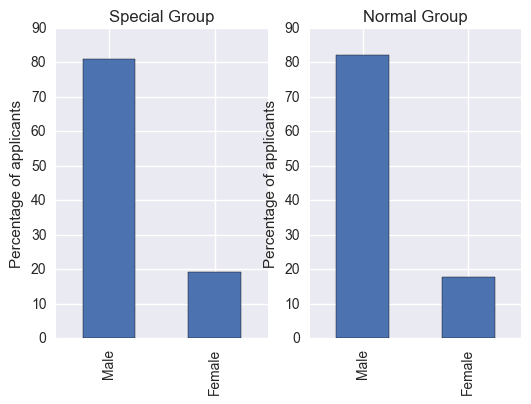

In [1210]:
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
total_applicants = 110.0
plt1 = (train_special["Gender"].value_counts()/(train_special.shape[0])*100).plot(kind="bar",ax=ax1,title="Special Group")
plt1.set_ylabel("Percentage of applicants")
plt2 = (train_normal["Gender"].value_counts()/(train_normal.shape[0])*100).plot(kind="bar",ax=ax2,title="Normal Group")
plt2.set_ylabel("Percentage of applicants")



**Fig 15. Proportion of males and females in the special group compared to normal group**

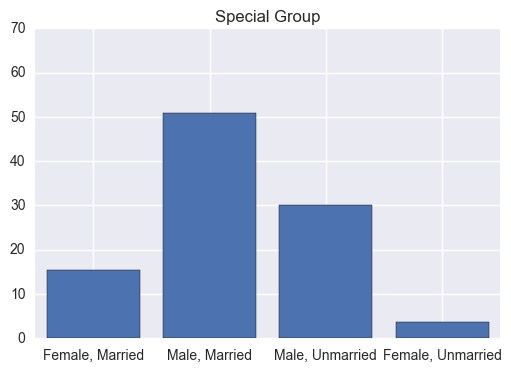

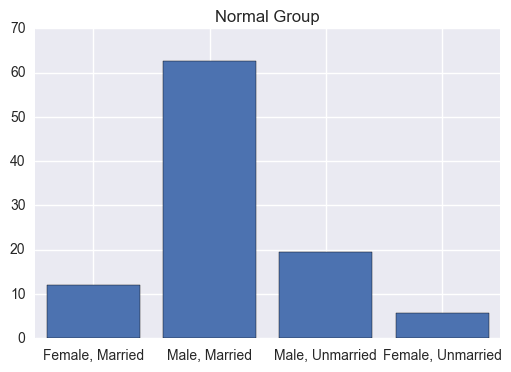

In [1220]:
fig1 = plt.figure()
total_applicants = train_special.shape[0]
mm_spec = (train_special.groupby("Gender").get_group("Male")["Married"].value_counts()[0])*100/total_applicants
mu_spec = (train_special.groupby("Gender").get_group("Male")["Married"].value_counts()[1])*100/total_applicants
fm_spec = (train_special.groupby("Gender").get_group("Female")["Married"].value_counts()[0])*100/total_applicants
fu_spec = (train_special.groupby("Gender").get_group("Female")["Married"].value_counts()[1])*100/total_applicants

plot_list1 = {'Male, Married':mm_spec,'Male, Unmarried':mu_spec,'Female, Married':fm_spec,'Female, Unmarried':fu_spec}
plt.bar(range(len(plot_list1)),plot_list1.values(),align="center")
plt.xticks(range(len(plot_list1)),plot_list1.keys())
plt.title("Special Group")
plt.ylim(0,70)

fig2 = plt.figure()
total_applicants = train_normal.shape[0]
mm_norm = (train_normal.groupby("Gender").get_group("Male")["Married"].value_counts()[0])*100/total_applicants
mu_norm = (train_normal.groupby("Gender").get_group("Male")["Married"].value_counts()[1])*100/total_applicants
fm_norm = (train_normal.groupby("Gender").get_group("Female")["Married"].value_counts()[0])*100/total_applicants
fu_norm = (train_normal.groupby("Gender").get_group("Female")["Married"].value_counts()[1])*100/total_applicants

plot_list2 = {'Male, Married':mm_norm,'Male, Unmarried':mu_norm,'Female, Married':fm_norm,'Female, Unmarried':fu_norm}
plt.bar(range(len(plot_list2)),plot_list2.values(),align="center")
plt.xticks(range(len(plot_list2)),plot_list2.keys())
plt.ylim(0,70)
plt.title("Normal Group")



**Fig 16. Proportion of males and females according to marital status in the normal and special group**

The proportion of males in the special group is about the same as that in the normal group. The percentage of males and females according to marital status are also similar (see figure below), though the proportion of married males are slightly lower in the special group than in the normal group, and the percentage of unmarried males is slighthy higher in the special group than in the normal group

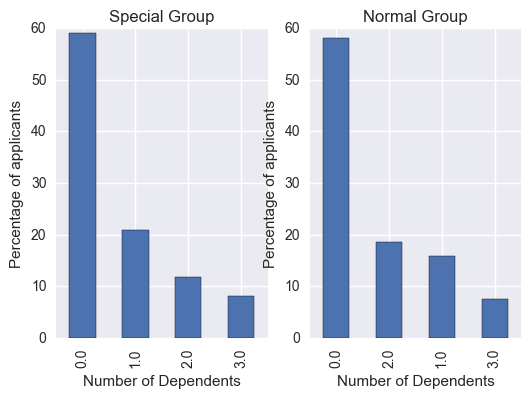

In [1222]:
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

plot1 = (train_special["Dependents"].value_counts()/(train_special.shape[0])*100).plot(kind="bar",ax=ax1,title="Special Group")
plot1.set_ylabel("Percentage of applicants")
plot1.set_xlabel("Number of Dependents")

plot2 = (train_normal["Dependents"].value_counts()/(train_normal.shape[0])*100).plot(kind="bar",ax=ax2,title="Normal Group")
plot2.set_ylabel("Percentage of applicants")
plot2.set_xlabel("Number of Dependents")

**Fig 17. Percentage of applicants according to number of dependents in the normal and special group**

The percentage distribution of applicants according to number of dependents are very similar, with a very slight difference seen in the number of applicants with 1 and 2 dependents, although it is only marginal

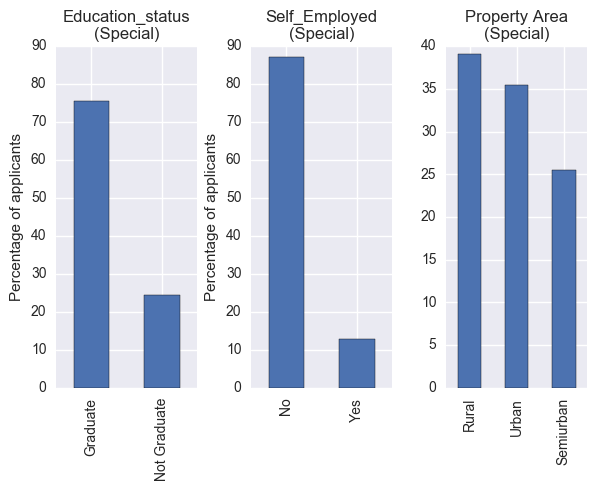

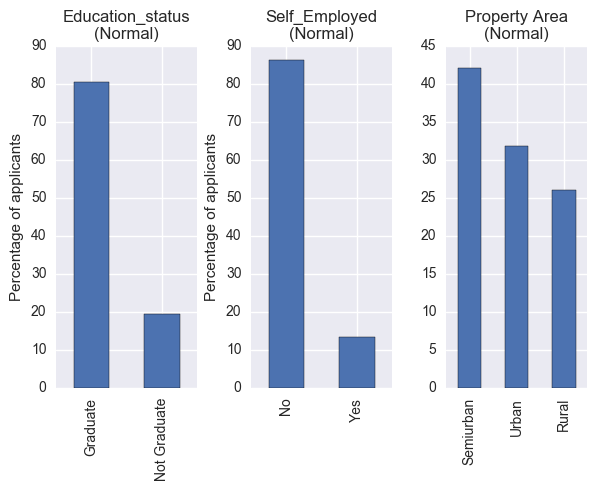

In [1228]:
fig1 = plt.figure()
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

fig1.tight_layout()
total_applicants = train_special.shape[0]
plot1 = (train_special["Education"].value_counts()/(total_applicants)*100).plot(kind="bar",ax=ax1)
plot1.set_ylabel("Percentage of applicants")
#plot1.set_xlabel("Education_status")
plot1.set_title("Education_status\n(Special)")
plot1.set_ylim(0,90)

plot2 = (train_special["Self_Employed"].value_counts()/(total_applicants)*100).plot(kind="bar",ax=ax2)
plot2.set_ylabel("Percentage of applicants")
#plot2.set_xlabel("Employment_status")
plot2.set_title("Self_Employed\n(Special)")
plot2.set_ylim(0,90)


plot3 = (train_special["Property_Area"].value_counts()*100/train_special.shape[0]).plot(kind="bar",ax=ax3,title="Property Area\n(Special)")

fig2 = plt.figure()
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

fig2.tight_layout()
total_applicants = train_normal.shape[0]
plot3 = (train_normal["Education"].value_counts()/(total_applicants)*100).plot(kind="bar",ax=ax1)
plot3.set_ylabel("Percentage of applicants")
#plot1.set_xlabel("Education_status")
plot3.set_title("Education_status\n(Normal)")
plot3.set_ylim(0,90)

plot4 = (train_normal["Self_Employed"].value_counts()/(total_applicants)*100).plot(kind="bar",ax=ax2)
plot4.set_ylabel("Percentage of applicants")
#plo2.set_xlabel("Employment_status")
plot4.set_title("Self_Employed\n(Normal)")
plot4.set_ylim(0,90)


plot3 = (train_normal["Property_Area"].value_counts()*100/train_normal.shape[0]).plot(kind="bar",ax=ax3,title="Property Area\n(Normal)")


**Fig 18. Percentage of applicants according to Education, Employment and Property Area in the normal and special group**

The percentage of graduates is slightly lower in this group, (~ 75%) compared to the normal group, which has over 80% graduates, however, the difference is not very high. The distribution of self-employed vs non self-employed applicants are almost the same. However, in case of property location inside the special group, the majority are now in rural areas  (close to 40%), whereas the semi-urban properties are the least. This is in contrast to the normal group where semi-urban areas formed around 37%, urban areas form about 32%, and rural areas form just over 25%. Thus, there is slightly higher chance of rejection if the property is in rural area, despite having a good credit history. 

Lastly lets compare the income and loan amounts of this group. For this purpose, it is better to compare the new variable "DTI", as that will help us know convey the information contained in applicantincome, co-appliant income and loan amount together.

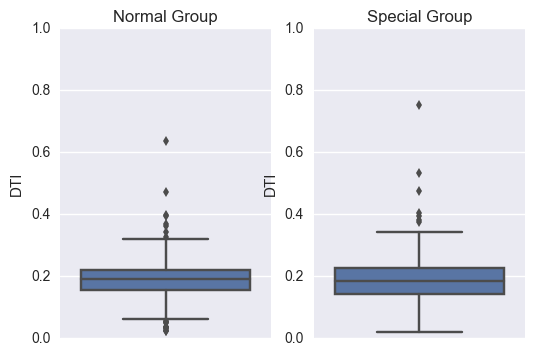

In [1230]:
calculate_EMI(all_data,8.5)
calculate_EMI(train_special,8.5)
train_normal["DTI"] = train_normal["EMI"]/(train_normal["ApplicantIncome"]+train_normal["CoapplicantIncome"])
train_special["DTI"] = train_special["EMI"]/(train_special["ApplicantIncome"]+train_special["CoapplicantIncome"])
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
#ax3 = plt.subplot(133)
plot1 = sns.boxplot(y="DTI",data=train_normal,ax=ax1)
plot2 = sns.boxplot(y="DTI",data=train_special,ax=ax2)
plot1.set_ylim(0,1.0)
plot2.set_ylim(0,1.0)
plot1.set_title("Normal Group")
plot2.set_title("Special Group")
#sns.boxplot(y="LoanAmount",data=train_special,ax=ax3)


**Fig 19. Variation of Debt to Income Ratio of the applicants in the normal and special group**

Again, there is no significant difference between the Debt to Income ratio of the normal andspecial group, which is interesting since one would expect a considerable difference in this variable to be a reason for the rejection of loan application despite a good credit history.

Thus, we see that it is really difficult to point out any significant difference between the two cases, i.e., why for certain cases the loans were rejected despite having a good credit history by observing the composition of the data sets, which also partially explains the difficulty of the algorithms in identifying those cases correctly. Perhaps more advanced algorithms will be able to detect these cases better, or perhpas having more data for the cases in the special group will help us detect the difference properly. In any case, more investigations is required, and what has been done till now does not form a conclusive analysis of the problem. The above models (logistic regression/decision tree/random forest) did achieve an accuracy of ~ 78% on the test set (as suggested by the leaderboard). However, any further improvmement of accuracy needs better prediction of the cases in the special group. Future work should be directed in this direction 